# Building R Predictor Model

In [2]:
# rm(list = ls())   # wipe workspace CLEAN

library(tidymodels)
library(dplyr)
library(tidyverse)
library(xgboost)
library(yardstick)
library(vip)
library(jsonlite)
library(glmnet)
library(ranger)

── Attaching packages ────────────────────────────────────── tidymodels 1.4.1 ──

✔ broom        1.0.10     ✔ recipes      1.3.1 
✔ dials        1.4.2      ✔ rsample      1.3.1 
✔ dplyr        1.1.4      ✔ tailor       0.1.0 
✔ ggplot2      4.0.0      ✔ tidyr        1.3.1 
✔ infer        1.0.9      ✔ tune         2.0.1 
✔ modeldata    1.5.1      ✔ workflows    1.3.0 
✔ parsnip      1.3.3      ✔ workflowsets 1.1.1 
✔ purrr        1.1.0      ✔ yardstick    1.3.2 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() mas

Importing dataframe created from notebook 04

In [4]:
training_df <- read_csv("../../../MIMIC_ED/processed/los_training_df.csv")

head(training_df)


Rows: 421233 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, race, disposition, icd_code, icd_title
dbl (9): stay_id, subject_id, hadm_id, ed_los_hours, acuity, medication_coun...
lgl (1): is_admitted

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


stay_id,subject_id,hadm_id,gender,race,ed_los_hours,acuity,is_admitted,disposition,medication_count,hosp_los_hours,log_hosp_los_hours,icd_code,icd_version,icd_title
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
30000012,11714491,21562392,F,WHITE,5.616667,2,TRUE,ADMITTED,14,65.00000,4.174387,5722,9,HEPATIC ENCEPHALOPATHY
30000012,11714491,21562392,F,WHITE,5.616667,2,TRUE,ADMITTED,14,65.00000,4.174387,5990,9,URIN TRACT INFECTION NOS
30000038,13821532,26255538,F,WHITE,3.300000,3,TRUE,ADMITTED,12,45.61667,3.820273,J189,10,"PNEUMONIA, UNSPECIFIED ORGANISM"
30000039,13340997,23100190,M,WHITE,8.516667,3,TRUE,ADMITTED,4,46.76667,3.845171,80709,9,FX MULT RIBS NOS-CLOSED
30000039,13340997,23100190,M,WHITE,8.516667,3,TRUE,ADMITTED,4,46.76667,3.845171,8054,9,FX LUMBAR VERTEBRA-CLOSE
30000039,13340997,23100190,M,WHITE,8.516667,3,TRUE,ADMITTED,4,46.76667,3.845171,8052,9,FX DORSAL VERTEBRA-CLOSE


In [5]:
colnames(training_df)

[1] "stay_id"            "subject_id"         "hadm_id"           
 [4] "gender"             "race"               "ed_los_hours"      
 [7] "acuity"             "is_admitted"        "disposition"       
[10] "medication_count"   "hosp_los_hours"     "log_hosp_los_hours"
[13] "icd_code"           "icd_version"        "icd_title"

### Splitting

In [12]:
set.seed(123)

data_split <- initial_split(training_df, prop = 0.8)
train <- training(data_split)
val  <- testing(data_split)


# Baseline (intercept-only model)

In [142]:

# --- 1️⃣ Prepare data ---
y_train <- train$log_hosp_los_hours    # training target (log LOS)
y_true  <- val$log_hosp_los_hours      # test/validation target (log LOS)

# --- 2️⃣ Baseline prediction: mean log LOS ---
mean_log_pred <- mean(y_train, na.rm = TRUE)
y_pred_log <- rep(mean_log_pred, length(y_true))  # same prediction for all rows

# --- 3️⃣ Back-transform to hours ---
y_true_hours <- expm1(y_true)      # actual LOS in hours
y_pred_hours <- expm1(y_pred_log)  # baseline predicted LOS in hours

# --- 4️⃣ Compute metrics in hours ---
mse_hours  <- mean((y_true_hours - y_pred_hours)^2)
rmse_hours <- sqrt(mse_hours)
mae_hours  <- mean(abs(y_true_hours - y_pred_hours))

# Compute R2 manually
sst <- sum((y_true_hours - mean(y_true_hours))^2)
sse <- sum((y_true_hours - y_pred_hours)^2)
r2_hours <- 1 - sse/sst

b_metrics <- tibble(
  mse  = mse_hours,
  rmse = rmse_hours,
  mae  = mae_hours,
  rsq  = r2_hours
) %>%
  pivot_longer(everything(),
               names_to = "metric",
               values_to = "value")
b_metrics

metric,value
<chr>,<dbl>
mse,25601.7991787
rmse,160.0056223
mae,75.9401157
rsq,-0.1095722


### Baseline Summary
`MSE = 25,601.80`	
Large average squared error (in hours²).

`RMSE = 160.01 hours`	On average, our baseline is off by ~160 hours (≈ 6.7 days).

`MAE = 75.94 hours`Median-sized error: baseline is off by ~76 hours (≈ 3.2 days) on average.

`RSQ = –0.1096`	The baseline performs worse than predicting the mean of the validation set.

# Model_v1:  `acuity` + `race` + `gender` + `ed_los_hours` + `medication_count`

Interaction features:

**acuity * ed_los_hours**
> This interaction allows the effect of ED length of stay to change depending on patient acuity.
In other words, the model can learn that:
> A high-acuity patient staying 1 extra hour may signal something very different than a low-acuity patient staying 1 extra hour.

**medication_count/(ed_los+hours)**
Medications given per hour in the ED.
> Instead of just counting how many meds they received, we’re adjusting for how long they were there.

In [14]:
simplify_race <- function(r) {
  r <- toupper(as.character(r))
  
  if (grepl("WHITE", r)) {
    "WHITE"
  } else if (grepl("BLACK", r) || grepl("AFRICAN", r)) {
    "BLACK"
  } else if (grepl("HISPANIC", r) || grepl("LATINO", r)) {
    "HISPANIC"
  } else if (grepl("ASIAN", r)) {
    "ASIAN"
  } else if (grepl("NATIVE", r) || grepl("PACIFIC", r) || grepl("ALASKA", r)) {
    "NATIVE/PI"
  } else {
    "OTHER"
  }
}

# Vectorized version for use inside recipes
simplify_race_vec <- function(r) {
  sapply(r, simplify_race)
}

In [22]:

los_recipe <- recipe(log_hosp_los_hours ~ acuity + race + gender + ed_los_hours + medication_count, 
                     data = train) %>%
  
  # Simplify race and convert to factor
  step_mutate(
    race = factor(simplify_race_vec(race))
  ) %>%
  
  
  # Interaction features
  step_mutate(
    acuity_ed = acuity * ed_los_hours,
    meds_per_hour = medication_count / (ed_los_hours + 0.01)
  ) %>%
  
  # Dummy encode
  step_dummy(all_nominal_predictors()) %>%
  
  # Remove zero-variance predictors
  step_zv(all_predictors())


rf_model <- boost_tree(
  trees = 500,
  learn_rate = 0.05,
  tree_depth = 4,
  min_n = 5,
  loss_reduction = 1.0,
  mtry = 8
) %>%
  set_engine("xgboost") %>%
  set_mode("regression")

rf_workflow <- workflow() %>%
  add_recipe(los_recipe) %>%
  add_model(rf_model)

rf_fit <- fit(rf_workflow, data = train)

print(class(rf_fit))

# saveRDS(rf_fit, "../models/model_v1.rds")

[1] "workflow"


In [27]:
pred <- predict(rf_fit, new_data = val) %>%
  mutate(pred_hosp_los_hours = expm1(.pred)) %>%
  bind_cols(val %>% select(hosp_los_hours))


v1_metrics = metrics(pred,
        truth = hosp_los_hours,
        estimate = pred_hosp_los_hours)


v1_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,153.46755701
rsq,standard,0.06890241
mae,standard,67.91164419


In [38]:
v1_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,153.46755701
rsq,standard,0.06890241
mae,standard,67.91164419


In [143]:
comparison_metrics <- v1_metrics %>%
                          left_join(b_metrics, by = c(".metric" = "metric"))%>%
                          rename(
                            v1 = .estimate,
                            baseline = value,
                            metric = .metric
                            ) %>%
                          select(-.estimator)

# Separate metrics
metrics_main <- comparison_metrics %>% filter(metric %in% c("rmse", "mae"))
metrics_rsq  <- comparison_metrics %>% filter(metric == "rsq")

metric,v1,baseline
<chr>,<dbl>,<dbl>
rmse,153.46756,160.00562
mae,67.91164,75.94012


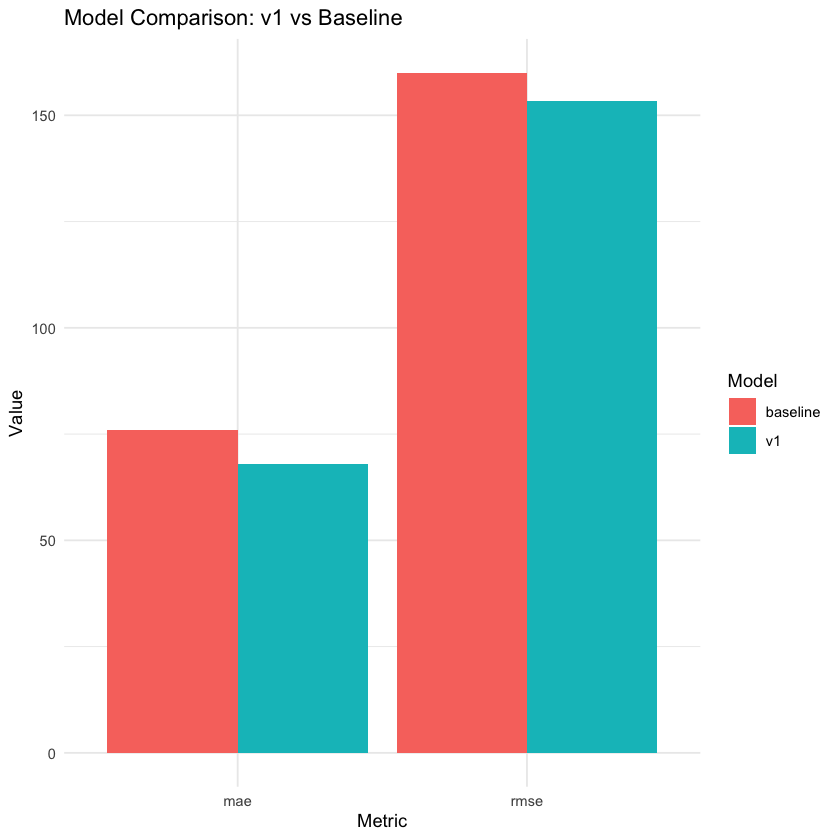

In [134]:
metrics_main

metrics_main <- metrics_main %>%
  pivot_longer(cols = c(v1, baseline),
               names_to = "model",
               values_to = "value")

ggplot(metrics_main, aes(x = metric, y = value, fill = model)) +
  geom_col(position = "dodge") +
  labs(title = "Model Comparison: v1 vs Baseline",
       x = "Metric",
       y = "Value",
       fill = "Model") +
  theme_minimal()

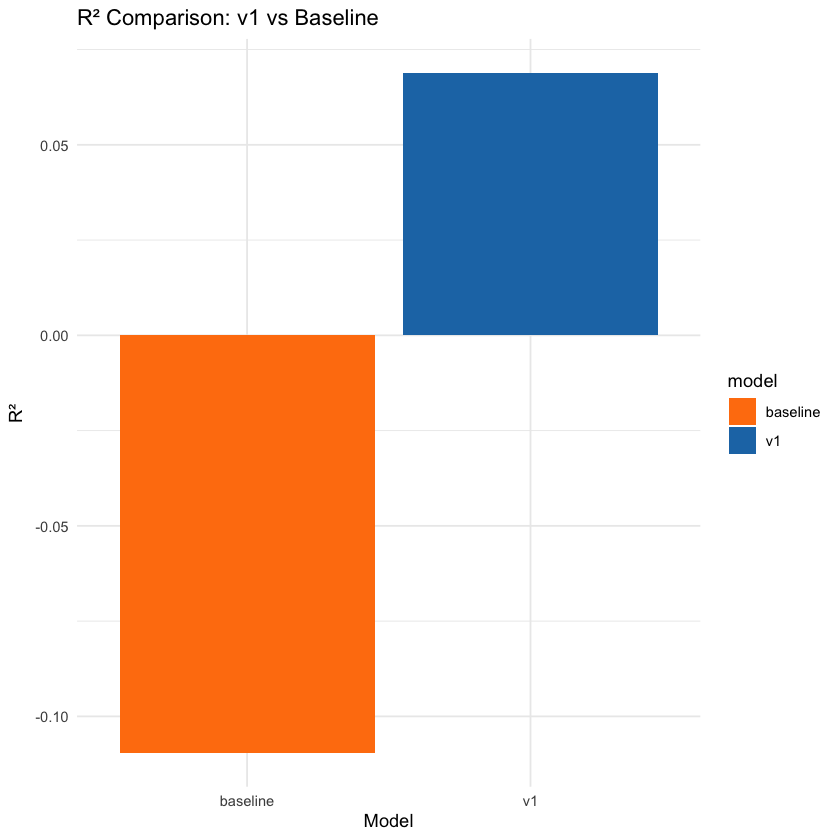

In [135]:
# plot RSQ
metrics_rsq <- metrics_rsq %>%
  pivot_longer(cols = c(v1, baseline),
               names_to = "model",
               values_to = "value")

# Plot
ggplot(metrics_rsq, aes(x = model, y = value, fill = model)) +
  geom_col() +
  labs(title = "R² Comparison: v1 vs Baseline",
       x = "Model",
       y = "R²") +
  theme_minimal() +
  scale_fill_manual(values = c("v1" = "#1f77b4", "baseline" = "#ff7f0e"))


mean_observed,mean_predicted,underprediction
<dbl>,<dbl>,<dbl>
578.1884,71.89889,506.2895


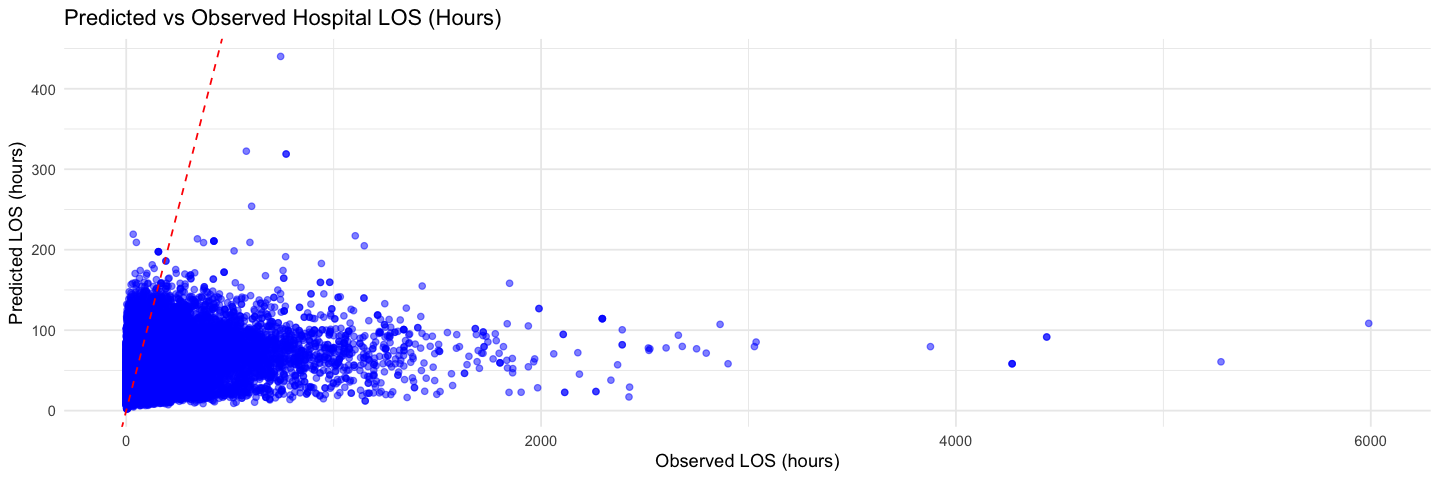

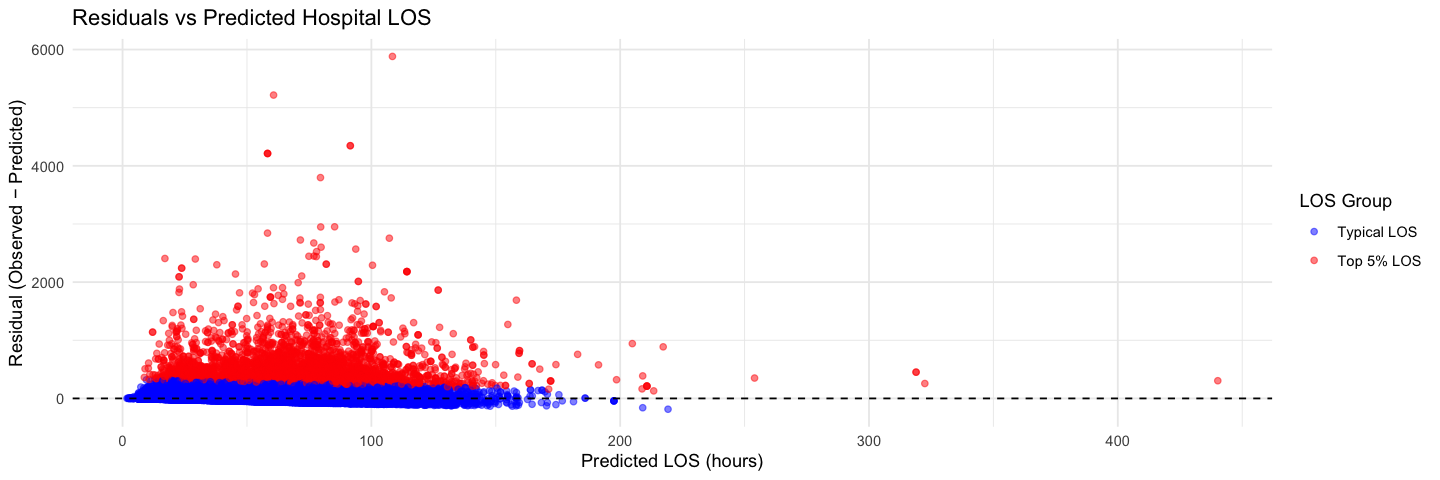

In [212]:
# library(ggplot2)

# Combine into a data frame
pred_df <- pred%>% select(pred_hosp_los_hours, hosp_los_hours)%>%
rename(
    Predicted = pred_hosp_los_hours,
    Observed = hosp_los_hours
)

pred_df <- pred_df %>%
  mutate(Residual = Observed - Predicted)


# 4️⃣ Summarize top 5% LOS underprediction

extreme_los_summary <- pred_df %>%
  filter(Observed >= top_5pct_val) %>%
  summarise(
    mean_observed = mean(Observed),
    mean_predicted = mean(Predicted),
    underprediction = mean(Observed - Predicted)
  )
extreme_los_summary

# ----------------------------
# 1️⃣ Predicted vs Observed scatter plot
# ----------------------------
p1 <- ggplot(pred_df, aes(x = Observed, y = Predicted)) +
  geom_point(alpha = 0.5, color = "blue") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(
    title = "Predicted vs Observed Hospital LOS (Hours)",
    x = "Observed LOS (hours)",
    y = "Predicted LOS (hours)"
  ) +
  theme_minimal()

p1

# ----------------------------
# 2️⃣ Residuals vs Predicted scatter plot
# ----------------------------
p2 <- ggplot(pred_df, aes(x = Predicted, y = Residual)) +
  geom_point(alpha = 0.5, color = "blue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    title = "Residuals vs Predicted Hospital LOS",
    x = "Predicted LOS (hours)",
    y = "Residual (Observed - Predicted)"
  ) +
  theme_minimal()


# ----------------------------
# 3️⃣ Residuals with top 5% LOS highlighted
# ----------------------------
top_5pct_val <- quantile(pred_df$Observed, 0.95)

p3 <- ggplot(pred_df, aes(x = Predicted, y = Residual)) +
  geom_point(alpha = 0.5, aes(color = Observed >= top_5pct_val)) +
  scale_color_manual(
    values = c("FALSE" = "blue", "TRUE" = "red"), 
    labels = c("Typical LOS", "Top 5% LOS")
  ) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(
    title = "Residuals vs Predicted Hospital LOS",
    x = "Predicted LOS (hours)",
    y = "Residual (Observed − Predicted)",
    color = "LOS Group"
  ) +
  theme_minimal()

p3


# ----------------------------
# 5️⃣ Optional: Save plots
# ----------------------------
# ggsave("../../results/modelv1_pred_vs_obs.png", p1, width = 12, height = 4, dpi = 300)
# ggsave("../../results/modelv1_residuals.png", p2, width = 12, height = 4, dpi = 300)
# ggsave("../../results/modelv1_residuals_top5.png", p3, width = 12, height = 4, dpi = 300)

In this scatter plot, the red line represents perfect prediction. We observe that our XGBoost model performs well for shorter stays, but begins to under predict for mid to longer stays. 

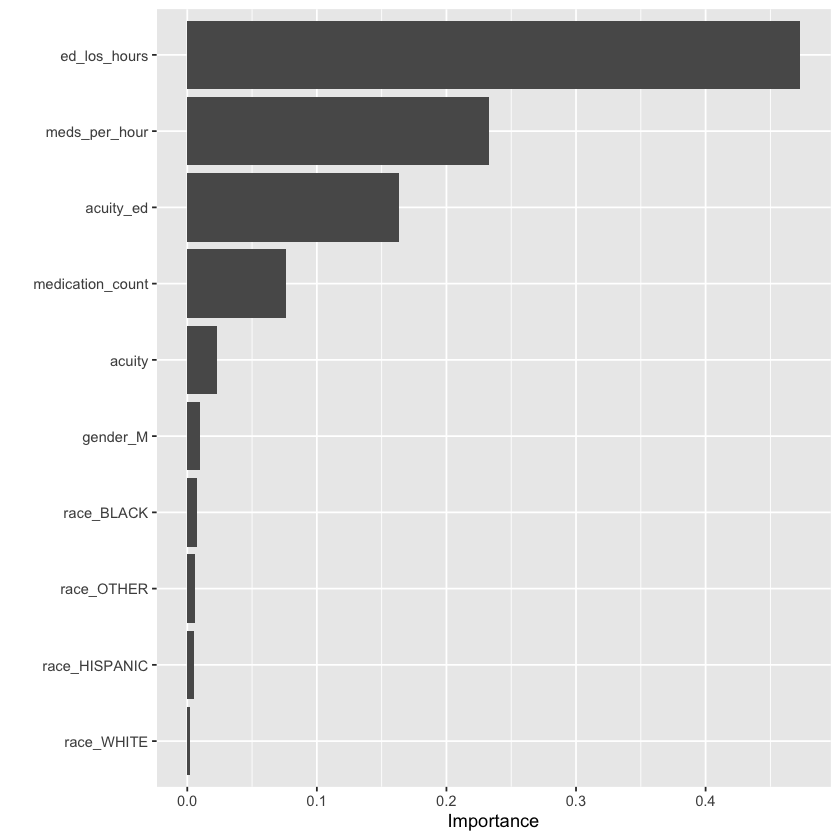

In [24]:
rf_fit %>%
  extract_fit_parsnip() %>%
  vip()

### Summary:
Our XGBoost model performed only slightly better than the baseline that used the mean log_hosp_los_hours as its prediction. Our R² value is very low (~6.3%), meaning that the current features (acuity, race, gender, ED LOS, and medication count) explain only a small fraction of the variability in hospital length of stay. Most of the variation in LOS remains unexplained, suggesting that additional features or more complex modeling would be needed to achieve substantially better predictive performance.

# Model_v2 Ensembling methods

For v2, we introduced three different models—Elastic Net, Random Forest, and XGBoost—because each captures different patterns in the data:

`Elastic Net`: A linear, regularized model that handles multicollinearity and provides a stable baseline.

`Random Forest`: A non-linear, tree-based model that reduces variance through bagging and captures interactions.

`XGBoost`: A boosted tree model that learns complex patterns and minimizes errors iteratively.

By training all three, we can compare their individual performance and later combine them into an ensemble. This approach leverages the strengths of each algorithm, reduces overfitting risk, and creates a more balanced and reliable predictive model than using XGBoost alone.

In [92]:
# ElasticNet
enet_model <- linear_reg(penalty = 0.1, mixture = 0.5) %>%
  set_engine("glmnet") %>%
  set_mode("regression")

# Random Forest
rf_model2 <- rand_forest(trees = 500, min_n = 5, mtry = 5) %>%
  set_engine("ranger") %>%
  set_mode("regression")

# XGBoost (your existing)
xgb_model <- boost_tree(
  trees = 500,
  learn_rate = 0.05,
  tree_depth = 4,
  min_n = 5,
  loss_reduction = 1.0,
  mtry = 8
) %>%
  set_engine("xgboost") %>%
  set_mode("regression")

In [93]:
rf_workflow2 <- workflow() %>% add_recipe(los_recipe) %>% add_model(rf_model2)
enet_workflow <- workflow() %>% add_recipe(los_recipe) %>% add_model(enet_model)
xgb_workflow <- workflow() %>% add_recipe(los_recipe) %>% add_model(xgb_model)


In [94]:
rf_fit2 <- fit(rf_workflow2, train)
enet_fit <- fit(enet_workflow, train)
xgb_fit <- fit(xgb_workflow, train)


In [156]:
pred_rf <- predict(rf_fit2, val) %>% pull(.pred)
pred_enet <- predict(enet_fit, val) %>% pull(.pred)
pred_xgb <- predict(xgb_fit, val) %>% pull(.pred)


In [157]:
#  predictions and truth
pred_ensemble <- (pred_rf + pred_enet + pred_xgb) / 3
truth <- val$log_hosp_los_hours


# Convert predictions & truth back to hours
pred_emsemble_hours <- exp(pred_ensemble)
truth_hours <- exp(truth)

# 1️⃣ RMSE (hours)
rmse_val <- sqrt(mean((truth_hours - pred_emsemble_hours)^2))

# 2️⃣ MAE (hours)
mae_val <- mean(abs(truth_hours - pred_emsemble_hours))

# 3️⃣ R² (hours)
rss <- sum((truth_hours - pred_emsemble_hours)^2)
tss <- sum((truth_hours - mean(truth_hours))^2)
rsq_val <- 1 - rss / tss

# Create tibble in long format
v1_1_metrics <- tibble(
  rmse = rmse_val,
  mae  = mae_val,
  rsq  = rsq_val
) %>%
  pivot_longer(everything(),
               names_to = "metric",
               values_to = "v1_1_value")

v1_1_metrics


metric,v1_1_value
<chr>,<dbl>
rmse,148.29930969
mae,63.39594456
rsq,0.04684542


In [165]:
comparison_metrics1 <- comparison_metrics %>%
  left_join(v1_1_metrics, by = "metric")

comparison_metrics1 <- comparison_metrics1 %>%
  rename(
    ensemble = v1_1_value,
    xgboost = v1
  ) %>%
  select(metric, baseline, xgboost, ensemble)

comparison_metrics1

metric,baseline,xgboost,ensemble
<chr>,<dbl>,<dbl>,<dbl>
rmse,160.0056223,153.46755701,148.29930969
rsq,-0.1095722,0.06890241,0.04684542
mae,75.9401157,67.91164419,63.39594456


metric,baseline,xgboost,ensemble
<chr>,<dbl>,<dbl>,<dbl>
rmse,160.0056223,153.46755701,148.29930969
rsq,-0.1095722,0.06890241,0.04684542
mae,75.9401157,67.91164419,63.39594456


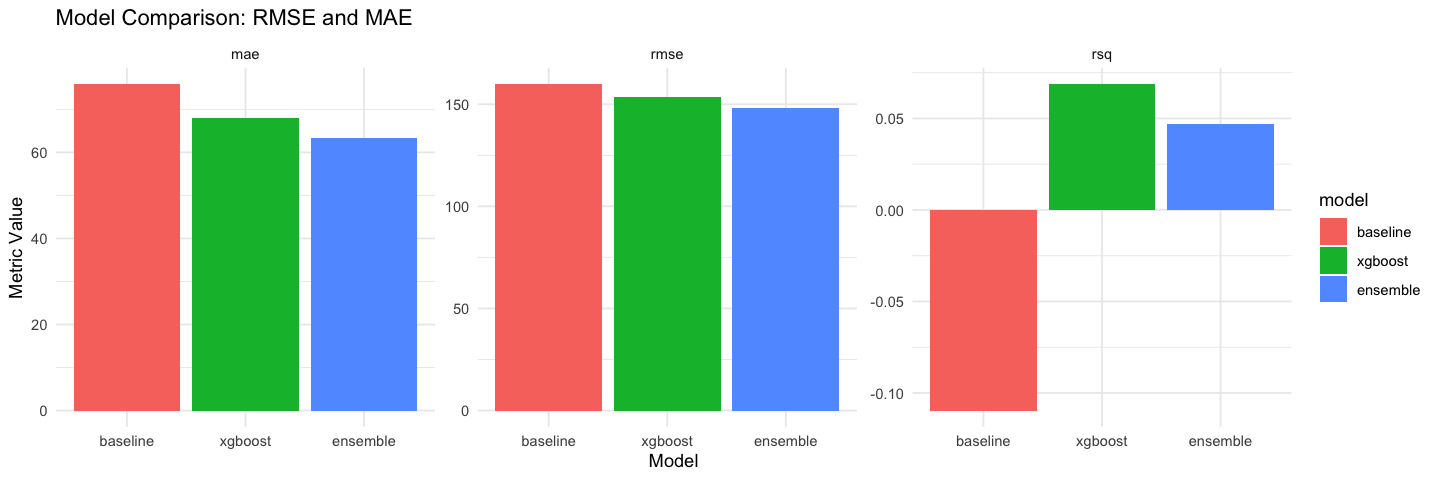

In [178]:
# reshape for plotting
metrics <- comparison_metrics1 
# %>% 
#         filter(metric %in% c("rmse", "mae")) 

metrics_long <- metrics %>%
  pivot_longer(cols = -metric,
               names_to = "model",
               values_to = "value")

metrics_long$model <- factor(
  metrics_long$model,
  levels = c("baseline", "xgboost", "ensemble")
)
# plot
options(repr.plot.width = 12, repr.plot.height = 4)


p <- ggplot(metrics_long, aes(x = model, y = value, fill = model)) +
  geom_col() +
  facet_wrap(~ metric, scales = "free_y") +
  labs(title = "Model Comparison: RMSE and MAE",
       x = "Model",
       y = "Metric Value") +
  theme_minimal() 


metrics
p

mean_observed,mean_predicted,underprediction
<dbl>,<dbl>,<dbl>
578.1884,89.05527,489.1332


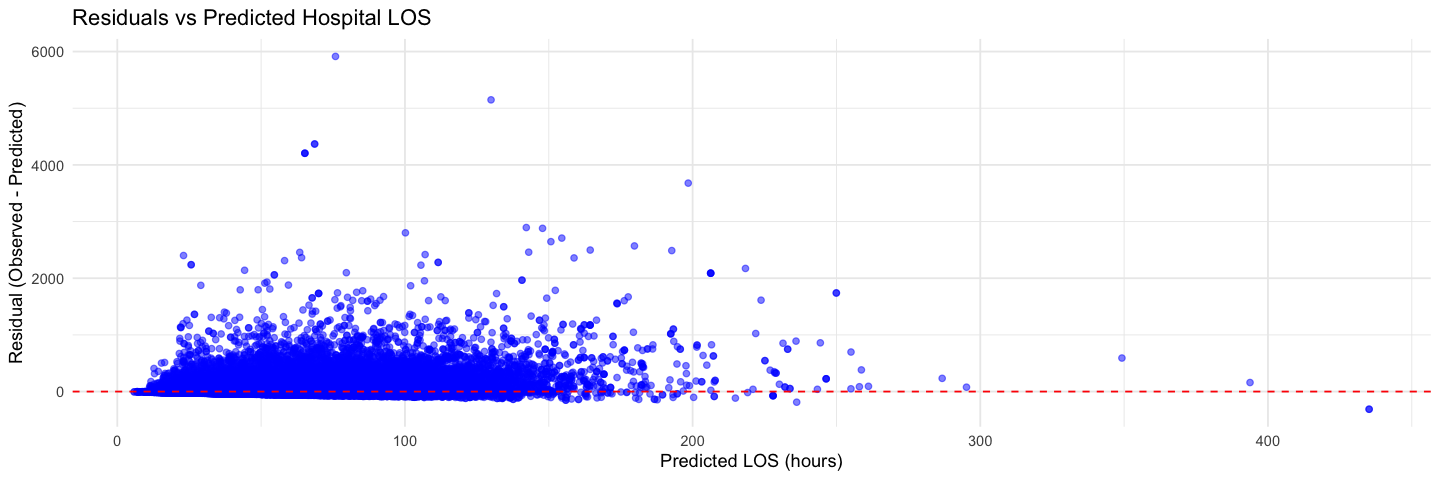

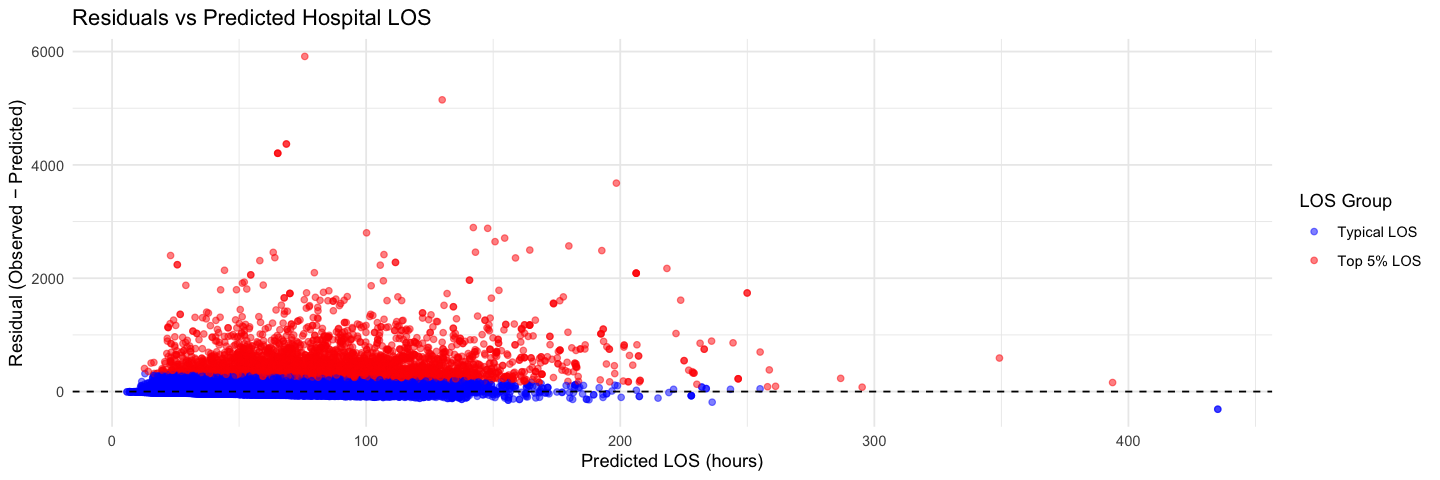

In [213]:
# library(ggplot2)

# Combine into a data frame
pred_df <- data.frame(
  Observed = truth_hours,
  Predicted = pred_emsemble_hours
)

pred_df <- pred_df %>%
  mutate(Residual = Observed - Predicted)

# Calculate the 95th percentile of observed LOS
top_5pct <- quantile(pred_df$Observed, 0.95)

# Filter top 5% longest LOS
extreme_los <- pred_df %>% filter(Observed >= top_5pct)

# Summarize
extreme_los_summary <- extreme_los %>%
  summarise(
    mean_observed = mean(Observed),
    mean_predicted = mean(Predicted),
    underprediction = mean(Observed - Predicted)
  )

extreme_los_summary


# Scatter plot
p2 <- ggplot(pred_df, aes(x = Observed, y = Predicted)) +
  geom_point(alpha = 0.5, color = "blue") +      # points
  geom_abline(slope = 1, intercept = 0,         # perfect prediction line
              linetype = "dashed", color = "red") +
  labs(
    title = "Model v2 Predicted vs Observed Hospital LOS (Hours)",
    x = "Observed LOS (hours)",
    y = "Predicted LOS (hours)"
  ) +
  theme_minimal()


p3 <- ggplot(pred_df, aes(x = Predicted, y = Residual)) +
  geom_point(alpha = 0.5, color = "blue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    title = "Residuals vs Predicted Hospital LOS",
    x = "Predicted LOS (hours)",
    y = "Residual (Observed - Predicted)"
  ) +
  theme_minimal()

p2



top_5pct_val <- quantile(pred_df$Observed, 0.95)

residual_top5_highlighted <- ggplot(pred_df, aes(x = Predicted, y = Residual)) +
  geom_point(alpha = 0.5, aes(color = Observed >= top_5pct_val)) +
  scale_color_manual(values = c("FALSE" = "blue", "TRUE" = "red"), 
                     labels = c("Typical LOS", "Top 5% LOS")) +
  geom_hline(yintercept = 0, linetype = "dashed",) +
  labs(title = "Residuals vs Predicted Hospital LOS",
       x = "Predicted LOS (hours)",
       y = "Residual (Observed − Predicted)",
       color = "LOS Group") +
  theme_minimal()
residual_top5_highlighted

# ggsave("../../results/modelv2_residual_vs_predicted.png", residual_top5_highlighted, width = 12, height = 4, dpi = 300)

In [179]:
# ggsave("../../results/model_comparison.png", p, width = 12, height = 4, dpi = 300)

In [151]:
# write_csv(comparison_metrics1, "comparison_metrics.csv")

## **Ensemble Model Summary:**

Our ensemble model delivers the most accurate predictions (lowest RMSE and MAE), outperforming both the baseline and your standalone XGBoost model, even though XGBoost slightly edges it out in R².

In [138]:
ensemble_models <- list(
  rf = rf_fit2,
  enet = enet_fit,
  xgb = xgb_fit
)

# Save to disk
# saveRDS(ensemble_models, "../models/model_v2.rds")

# Model_v3 - Including `icd_codes` [tbd]

To improve our initial model, we want to utilize icd codes, but they are version 9 and 10, which map to different chapter names/titles. We want to map the codes to their respective Clinical Classifications Software, and from there

In [121]:
remotes::install_github("jackwasey/icd")
library(icd)
packageVersion("icd")

Using GitHub PAT from the git credential store.

Skipping install of 'icd' from a github remote, the SHA1 (c571d8c1) has not changed since last install.
  Use `force = TRUE` to force installation



[1] ‘4.0.9.9000’

In [185]:
# ls("package:icd");

Importing triage data to get icd codes

In [186]:
triage_df <- read_csv("MIMIC_ED/processed/ed_diagnoses.csv");
head(triage_df)

Rows: 898730 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): icd_code, icd_title
dbl (3): stay_id, subject_id, icd_version

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


stay_id,subject_id,icd_code,icd_version,icd_title
<dbl>,<dbl>,<chr>,<dbl>,<chr>
30000012,11714491,5722,9,HEPATIC ENCEPHALOPATHY
30000012,11714491,5990,9,URIN TRACT INFECTION NOS
30000017,14230614,V08,9,ASYMPTOMATIC HIV INFECTION
30000017,14230614,4019,9,HYPERTENSION NOS
30000017,14230614,30300,9,AC ALCOHOL INTOX-UNSPEC
30000017,14230614,V600,9,LACK OF HOUSING


In [123]:
# triage_df <- triage_df %>%
#   mutate(
#     chapter = ifelse(
#       icd_version == 10,
#       substr(icd_code, 1, 1),       # ICD-10
#       substr(icd_code, 1, 1)        # ICD-9 (simple chapter)
#     )
#   )

In [187]:
head(triage_df)

stay_id,subject_id,icd_code,icd_version,icd_title
<dbl>,<dbl>,<chr>,<dbl>,<chr>
30000012,11714491,5722,9,HEPATIC ENCEPHALOPATHY
30000012,11714491,5990,9,URIN TRACT INFECTION NOS
30000017,14230614,V08,9,ASYMPTOMATIC HIV INFECTION
30000017,14230614,4019,9,HYPERTENSION NOS
30000017,14230614,30300,9,AC ALCOHOL INTOX-UNSPEC
30000017,14230614,V600,9,LACK OF HOUSING


Then, we deal with icd9 and icd10 separately. After separating the two versions, we then want to map then to their ccs according to their version by computing their **comorbidity**. Comorbidity refers to the presence of one or more additional medical conditions in a patient alongside a primary condition. In the hospital data context, ICD codes capture diagnoses for each stay. By analyzing the ICD codes, we can identify which comorbidities are present for each patient.

> ***Why We Compute Comorbidities***
> - Summarize Many Diagnoses into Meaningful Categories
> - Each patient can have dozens of ICD codes.
> - Comorbidity mapping groups related diagnoses into clinically meaningful categories, such as CHF, diabetes, liver disease, or pulmonary disease.

In [177]:
icd9_only <- triage_df %>%
  filter(icd_version == 9) 

# Step 2: Force codes to character
icd9_only$icd_code <- as.character(icd9_only$icd_code)

# Step 3: Force ICD-9 class (important!)
icd9_only$icd_code <- as.icd9(icd9_only$icd_code)

# Step 4: Prepare two-column input (ID first, code second)
df_comorb_input <- icd9_only %>%
  select(stay_id, icd_code)

# Step 5: Compute comorbidity 
comorb9 <- icd9_comorbid(df_comorb_input, map = icd9_map_ahrq)

[1] TRUE

In [178]:
icd10_only <- triage_df %>%
  filter(icd_version == 10) 

# Step 2: Force codes to character
icd10_only$icd_code <- as.character(icd10_only$icd_code)

# Step 3: Force ICD-9 class (important!)
icd10_only$icd_code <- as.icd10(icd10_only$icd_code)

# Step 4: Prepare two-column input (ID first, code second)
df_comorb_input <- icd10_only %>%
  select(stay_id, icd_code)

# Step 5: Compute comorbidity
comorb10 <- icd10_comorbid(df_comorb_input, map = icd10_map_ahrq)

In [197]:
# check if all codes are valid icd10
all_valid_10 <- all(is.icd10(icd10_only$icd_code))
all_valid_10

[1] TRUE

In [204]:
head(comorb9, 2)

,CHF,Valvular,PHTN,PVD,HTN,HTNcx,Paralysis,NeuroOther,Pulmonary,DM,⋯,Coagulopathy,Obesity,WeightLoss,FluidsLytes,BloodLoss,Anemia,Alcohol,Drugs,Psychoses,Depression
30000012,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
30000017,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE


In [205]:
head(comorb, 2)

,CHF,Valvular,PHTN,PVD,HTN,HTNcx,Paralysis,NeuroOther,Pulmonary,DM,⋯,Coagulopathy,Obesity,WeightLoss,FluidsLytes,BloodLoss,Anemia,Alcohol,Drugs,Psychoses,Depression
30000038,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
30000094,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


Now that we have our comorbidity tables for 9 and 10 versions, lets merge it with our training dataset.

In [210]:
# Convert to data frame
comorb9_df <- as.data.frame(comorb9)
comorb10_df <- as.data.frame(comorb10)

# Then align columns 
all_cols <- union(colnames(comorb9_df), colnames(comorb10_df))
for(col in setdiff(all_cols, colnames(comorb9_df))) comorb9_df[[col]] <- FALSE
for(col in setdiff(all_cols, colnames(comorb10_df))) comorb10_df[[col]] <- FALSE

comorb9_df <- comorb9_df[, all_cols]
comorb10_df <- comorb10_df[, all_cols]

# Bind rows
comorb_all <- dplyr::bind_rows(comorb9_df, comorb10_df)


In [222]:
# reset index
comorb_all <- comorb_all %>%
  rownames_to_column(var = "stay_id")

ERROR: [1m[33mError[39m in `rownames_to_column()`:[22m
[1m[22m[33m![39m Column name `stay_id` must not be duplicated.
[1mCaused by error in `repaired_names()`:[22m
[33m![39m Names must be unique.
[31m✖[39m These names are duplicated:
  * "stay_id" at locations 1 and 32.


In [223]:
# convert stay_id to int
comorb_all$stay_id <- as.numeric(comorb_all$stay_id)


In [234]:
comorb_all <- comorb_all %>%
  mutate(across(everything(), ~ as.numeric(.)))

In [235]:
head(comorb_all)

,stay_id,CHF,Valvular,PHTN,PVD,HTN,HTNcx,Paralysis,NeuroOther,Pulmonary,⋯,Coagulopathy,Obesity,WeightLoss,FluidsLytes,BloodLoss,Anemia,Alcohol,Drugs,Psychoses,Depression
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,30000012,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,30000017,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
3,30000039,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,30000055,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,30000177,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,30000202,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [236]:
X_df <- training_df %>%
  left_join(comorb_all, by = "stay_id")

In [237]:
head(X_df)

stay_id,subject_id,hadm_id,gender,race,ed_los_hours,acuity,is_admitted,disposition,medication_count,⋯,Coagulopathy,Obesity,WeightLoss,FluidsLytes,BloodLoss,Anemia,Alcohol,Drugs,Psychoses,Depression
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30000012,11714491,21562392,F,WHITE,5.616667,2,TRUE,ADMITTED,14,⋯,0,0,0,0,0,0,0,0,0,0
30000038,13821532,26255538,F,WHITE,3.300000,3,TRUE,ADMITTED,12,⋯,0,0,0,0,0,0,0,0,0,0
30000039,13340997,23100190,M,WHITE,8.516667,3,TRUE,ADMITTED,4,⋯,0,0,0,0,0,0,0,0,0,0
30000177,17937834,23831044,M,ASIAN,4.966667,2,TRUE,ADMITTED,16,⋯,0,0,0,0,0,0,0,0,0,0
30000204,11615015,25540031,M,WHITE,12.150000,3,TRUE,HOME,10,⋯,0,0,0,0,0,0,1,0,1,0
30000252,18684072,28532292,F,WHITE,23.066667,2,TRUE,HOME,10,⋯,0,0,0,0,0,0,0,0,0,0


In [238]:
data_split <- initial_split(X_df, prop = 0.8)
train <- training(data_split)
val  <- testing(data_split)


In [240]:
object.size(train) / 1024^2  # in MB

58.9 bytes

In [239]:
# include all other columns
los_recipe <- recipe(log_hosp_los_hours ~ acuity + race + gender + ed_los_hours + medication_count + ., 
                     data = train) %>%
  
  # Simplify race and convert to factor
  step_mutate(
    race = factor(simplify_race_vec(race))
  ) %>%
  
  
  # Interaction features
  step_mutate(
    acuity_ed = acuity * ed_los_hours,
    meds_per_hour = medication_count / (ed_los_hours + 0.01)
  ) %>%
  
  # Dummy encode
  step_dummy(all_nominal_predictors()) %>%
  
  # Remove zero-variance predictors
  step_zv(all_predictors())


rf_model <- boost_tree(
  trees = 500,
  learn_rate = 0.05,
  tree_depth = 4,
  min_n = 5,
  loss_reduction = 1.0,
  mtry = 8
) %>%
  set_engine("xgboost") %>%
  set_mode("regression")

rf_workflow <- workflow() %>%
  add_recipe(los_recipe) %>%
  add_model(rf_model)

rf_fit <- fit(rf_workflow, data = train)

print(class(rf_fit))

saveRDS(rf_fit, "model_v2.rds")

[1] "workflow"


ERROR: Error: vector memory exhausted (limit reached?)


In [ ]:
pred <- predict(rf_fit, new_data = test) %>%
  mutate(pred_hosp_los_hours = expm1(.pred)) %>%
  bind_cols(test %>% select(hosp_los_hours))


metrics(pred,
        truth = hosp_los_hours,
        estimate = pred_hosp_los_hours)
